# Learning the Inverse Design Map: Hamiltonian to Geometry

In this tutorial, we learn the inverse map from Hamiltonian parameters to geometry using `SQuADDS`. We first train regression models to interpolate design parameters, then apply symbolic modeling with KANs for interpretability. Predictions are validated against full-wave simulations at interpolation targets.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

## Collecting Training Data from `SQuADDS`

For this tutorial, we will be trying to predict the design space variables of a qubit-cavity system.

In [3]:
from squadds import SQuADDS_DB, Analyzer
import pandas as pd

In [ ]:
db = SQuADDS_DB()
db.select_system(["qubit","cavity_claw"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_resonator_type("quarter")
merged_df = db.create_system_df()
analyzer = Analyzer(db)

Recall that we need all Hamiltonian parameters to generate a **complete** training dataset. For this tutorial, I have chosen some demo targets to generate the training data. 

In [ ]:
seed_data_df = pd.read_csv('data/seed_data.csv')
seed_data_df

Now we generate the training data using this `seed_df`

In [ ]:
from squadds.interpolations.utils import generate_qubit_cavity_training_data

training_df = generate_qubit_cavity_training_data(analyzer, seed_data_df,"data/training_data.parquet")

As we can see the `training_df` has information about both the design space variables (**our targets**) and its corresponding Hamiltonian parameters (**our features**).

Now, we are ready to train an ML model!

## Preprocessing the Training Data (a.k.a Feature Engineering)

Let's first import some standard libraries in the ML world.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import os

import joblib
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [108]:
os.makedirs("figures", exist_ok=True)
os.makedirs("model", exist_ok=True)
os.makedirs("sims", exist_ok=True)

In [110]:
training_df = pd.read_parquet("data/training_data.parquet")
training_df.head()

,claw_length,cavity_frequency_GHz,kappa_kHz,EC,EJ,qubit_frequency_GHz,anharmonicity_MHz,g_MHz,cross_length,cross_gap,ground_spacing,coupling_length,total_length
0,160.0,8.963333,282.985474,0.119465,16.346243,3.829124,-128.92902,52.250558,310.0,30.0,10.0,200.0,2700.0
1,160.0,6.911806,689.394209,0.119465,16.346243,3.829124,-128.92902,40.291451,310.0,30.0,10.0,500.0,3400.0
2,160.0,8.968642,205.609615,0.119465,16.346243,3.829124,-128.92902,52.281505,310.0,30.0,10.0,200.0,2700.0
3,160.0,6.767688,36.337103,0.119465,16.346243,3.829124,-128.92902,39.451337,310.0,30.0,10.0,100.0,3900.0
4,160.0,6.576639,136.678808,0.119465,16.346243,3.829124,-128.92902,38.337641,310.0,30.0,10.0,230.0,3900.0


Although there should not be any duplicates in the training data, we will remove them just in case.

In [111]:
training_df = training_df.drop_duplicates()

# reset the index
training_df.reset_index(drop=True, inplace=True)

Now we can split the data into features (`X` - the Hamiltonian parameters) and targets (`y` - the design space variables).

In [112]:
hamiltonian_parameters = ['qubit_frequency_GHz', 'anharmonicity_MHz', 'cavity_frequency_GHz', 'kappa_kHz', 'g_MHz']
design_parameters = ['cross_length', 'claw_length','coupling_length', 'total_length','ground_spacing']

In [113]:
X = training_df[hamiltonian_parameters].values # Hamiltonian parameters
y = training_df[design_parameters].values # Design parameters

Now, we can split the data into training and testing sets.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

Polynomial features help capture non-linear relationships by generating combinations of input features ($n$) raised to powers up to a specified degree ($d$). 

The resulting feature set includes original features, squared terms, and interaction terms (size $ \binom{n+d}{d}$), allowing linear models to fit more complex patterns. 

We will use the `PolynomialFeatures` class from `sklearn.preprocessing` to generate polynomial features.

In [115]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Save the polynomial feature transformer
joblib.dump(poly, 'model/poly_transformer.pkl')

['model/poly_transformer.pkl']

In [116]:
X_train_poly.shape, X_train.shape

((17268, 55), (17268, 5))

Finally, we need to normalize both the features and the target values. This ensures that all data is on the same scale, which helps the model learn more effectively. We use `StandardScaler` from `sklearn.preprocessing` to do this.

In [117]:
# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_train_poly = scaler_X.fit_transform(X_train_poly)
X_test_poly = scaler_X.transform(X_test_poly)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)


# Save the scalers
joblib.dump(scaler_X, 'model/scaler_X.pkl')
joblib.dump(scaler_y, 'model/scaler_y.pkl')

['model/scaler_y.pkl']

## ML Model Training:

### Simple Deep Neural Network (DNN)

We'll begin with a simple deep neural network (DNN) to predict the design space variables (`y`) from the Hamiltonian parameters (`X`).

- The model consists of three hidden layers:
  - 256, 128, and 64 neurons, respectively.
  - Each layer uses ReLU activation.
- To improve generalization and reduce overfitting:
  - **Batch Normalization** is applied after each layer.
  - **Dropout (30%)** is applied after each layer.
- The output layer matches the number of design variables.
- The optimizer used is **Adam** with a learning rate of 0.001, and the loss function is **mean squared error**.

In [118]:
def simple_dnn_model(neurons1=256, neurons2=128, neurons3=64, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons1, input_dim=X_train_poly.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(neurons2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(neurons3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(y_train.shape[1]))  # Output layer with the same number of neurons as output features
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


Now, we will train the DNN model on the training data for up to 500 epochs.

To ensure we save the best performing model, we have added a **ModelCheckpoint** callback that saves the model whenever the validation loss improves.

Additionally, we’ve added an **EarlyStopping** callback to stop training if the validation loss doesn’t improve for 10 consecutive epochs. This helps prevent overfitting and reduces unnecessary training time by restoring the model's weights to the best epoch.

In [119]:
# Define callbacks for early stopping and model checkpoint
model_checkpoint = ModelCheckpoint('model/simple_dnn.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')

# Train the model on the entire training data with callbacks
dnn = simple_dnn_model()
history = dnn.fit(X_train_poly, y_train, epochs=500, batch_size=16, verbose=1, validation_split=0.2, callbacks=[model_checkpoint,early_stopping])


Epoch 1/500
864/864 [==============================] - 2s 1ms/step - loss: 0.6989 - val_loss: 0.2175
Epoch 2/500
864/864 [==============================] - 1s 1ms/step - loss: 0.3420 - val_loss: 0.2072
Epoch 3/500
864/864 [==============================] - 1s 1ms/step - loss: 0.3146 - val_loss: 0.2070
Epoch 4/500
864/864 [==============================] - 1s 1ms/step - loss: 0.3096 - val_loss: 0.2018
Epoch 5/500
864/864 [==============================] - 1s 1ms/step - loss: 0.3025 - val_loss: 0.1805
Epoch 6/500
864/864 [==============================] - 1s 1ms/step - loss: 0.2894 - val_loss: 0.1756
Epoch 7/500
864/864 [==============================] - 1s 1ms/step - loss: 0.2836 - val_loss: 0.1631
Epoch 8/500
864/864 [==============================] - 1s 1ms/step - loss: 0.2757 - val_loss: 0.1669
Epoch 9/500
864/864 [==============================] - 1s 1ms/step - loss: 0.2691 - val_loss: 0.1471
Epoch 10/500
864/864 [==============================] - 1s 1ms/step - loss: 0.2642 - val_lo

### Training Evaluation

Let's look at the training history to see how the model performed during training.

In [120]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model/dnn_training_history.csv', index=False)

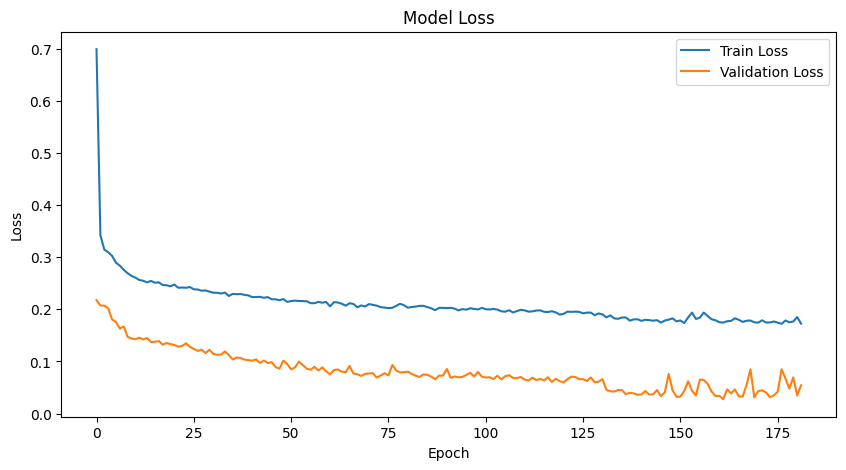

In [121]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('figures/dnn_training_validation_loss.png')
plt.show()

Now, we can evaluate the model on the test data.

In [122]:
# Evaluate on the test data
test_mse = dnn.evaluate(X_test_poly, y_test, verbose=0)

# Predictions
y_pred = dnn.predict(X_test_poly)

96/96 [==============================] - 0s 574us/step


Lets not forget to inverse transform the predictions and actual values to get them back to original scale.

In [ ]:
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

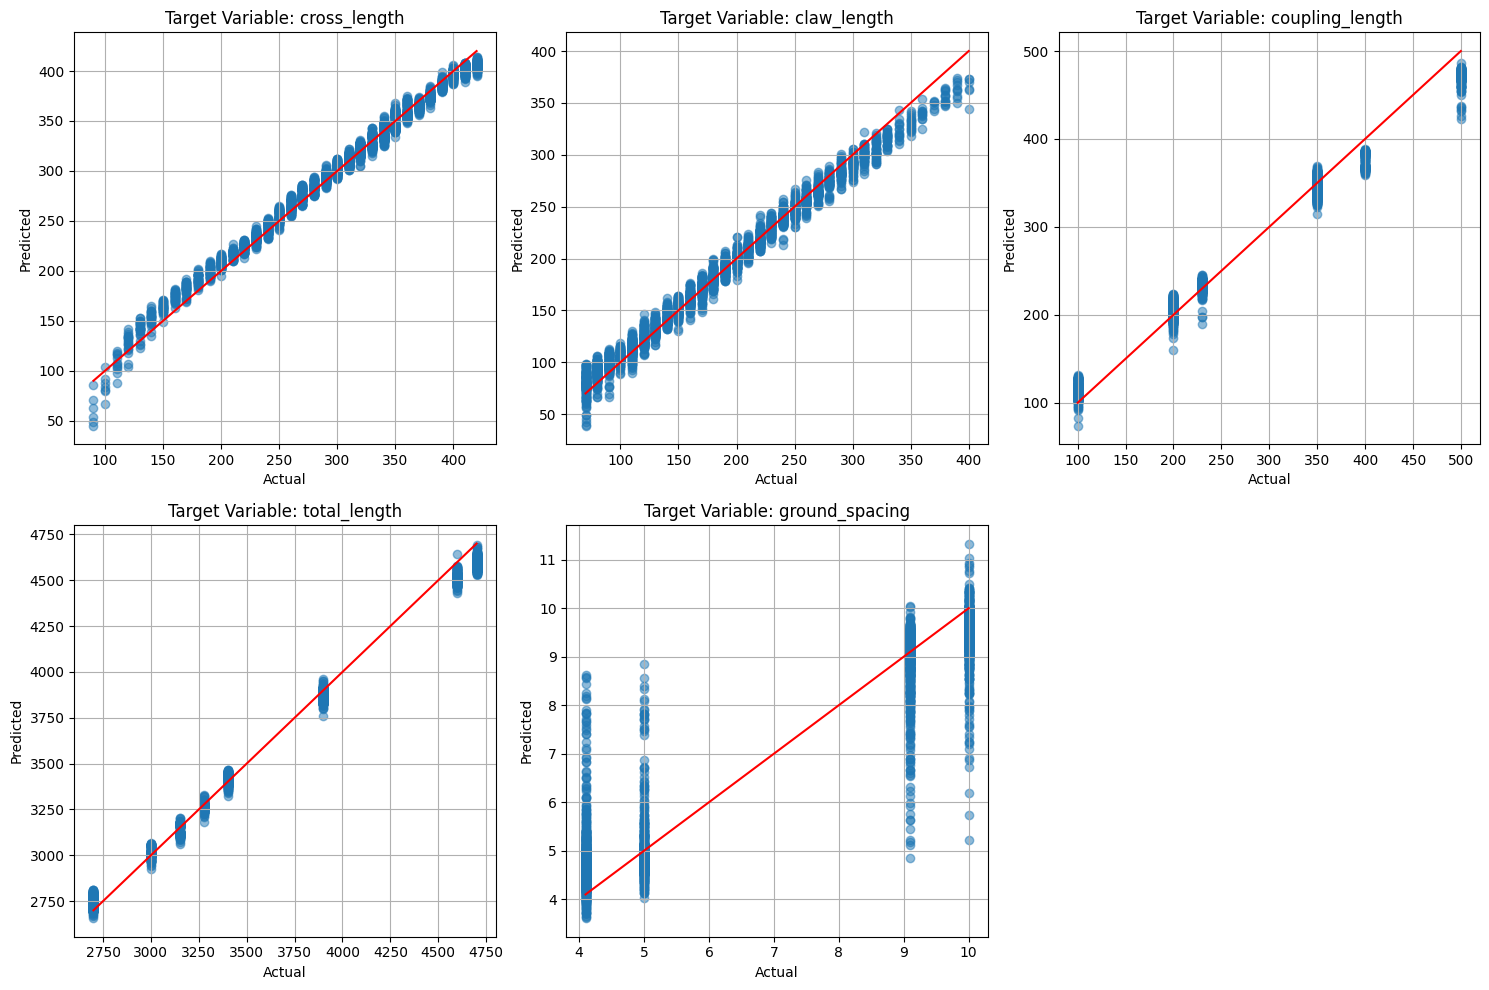

In [123]:
plt.figure(figsize=(15, 10))
for i in range(y_test.shape[1]):
    plt.subplot(2, 3, i + 1)
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r')
    plt.title(f'Target Variable: {design_parameters[i]}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
plt.tight_layout()
plt.savefig('figures/dnn_predicted_vs_actual.png')
plt.show()

Cool to see that such a basic model can generally capture the trends in the data (sort of haha). Of course, we can always improve the model by tuning the hyperparameters, adding more data, or using more sophisticated models.

Let's see how the model performs on some different data (`test_data`) points so that we can compare it to the scaling interpolation algorithm and the closest pre-simulation results . First, lets load the test dataframes.

In [124]:
test_data = pd.read_csv(f"data/test_data.csv")
test_data

,qubit_frequency_GHz,cavity_frequency_GHz,anharmonicity_MHz,kappa_kHz,g_MHz
0,4.621651,6.920735,-194.264031,163.433945,102.199270
1,5.514262,6.468747,-288.056418,127.175543,67.947060
2,5.039644,6.965297,-235.346921,35.666245,73.162768
3,4.241134,5.806681,-160.933514,153.074402,90.698935
4,4.879756,5.889439,-219.068857,97.823504,84.702197
5,5.448084,5.762119,-280.304835,211.778480,69.241372


Using the trained model to predict the design space variables for the test data and making sure to revert to the original scale.

In [125]:
# Extract input features
X_test = test_data[hamiltonian_parameters].values

# Transform input features
X_test_poly = poly.transform(X_test)
X_test_poly = scaler_X.transform(X_test_poly)

# Make predictions with the DNN model
y_pred_dnn = scaler_y.inverse_transform(dnn.predict(X_test_poly))

# save the predictions for future use
np.savetxt("data/y_pred_dnn.csv", y_pred_dnn, delimiter=",")

1/1 [==============================] - 0s 13ms/step


Loading the corresponding scaling interpolation (`interp_df`) and closest pre-simulated data points (`closest_df`) for comparison.

In [126]:
interp_df = pd.read_csv("data/scaling_interp_data.csv", index_col=0)
interp_df.columns = ['total_length', 'coupling_length', 'cross_length', 'claw_length', 'Lj', 'ground_spacing']

# Sort to match the order of target_names
scaling_interp_pred = interp_df[design_parameters].values

In [127]:
closest_df = pd.read_csv("data/closest_sim_data.csv", index_col=0)
closest_df.columns = ['total_length', 'coupling_length', 'cross_length', 'claw_length', 'ground_spacing', 'Ej']

# Sort to match the order of target_names
closest_results = closest_df[design_parameters].values

Moment of truth! Let's see how the model performs compared to the scaling (physics) interpolation and closest simulation results.

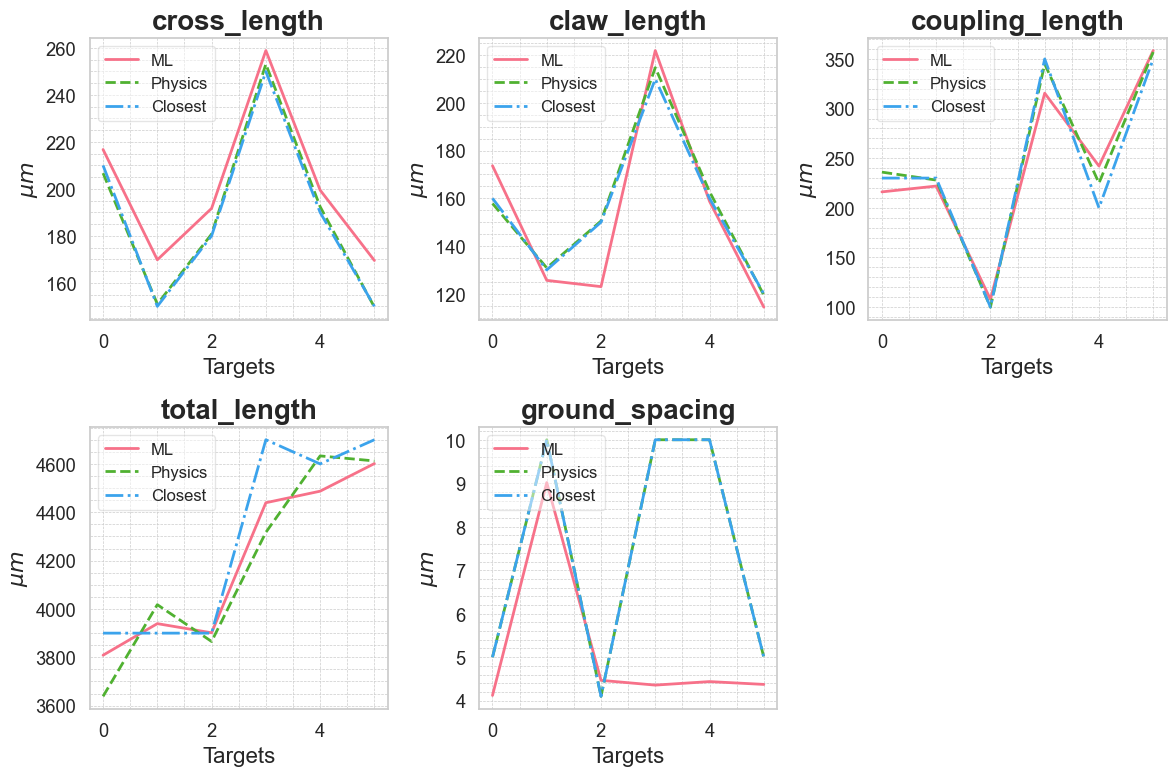

In [128]:
sns.set(style="whitegrid", font_scale=1.2)
colors = sns.color_palette("husl", 3)

# Plot comparisons of predicted values
plt.figure(figsize=(12, 8))


for i, target_name in enumerate(design_parameters):
    plt.subplot(2, 3, i + 1)
    plt.plot(y_pred_dnn[:, i], label='ML', color=colors[0], linewidth=2)
    plt.plot(scaling_interp_pred[:, i], label='Physics', color=colors[1], linewidth=2, linestyle='--')
    plt.plot(closest_results[:, i], label='Closest', color=colors[2], linewidth=2, linestyle='-.')
    plt.ylabel(r'$\mu m$', fontsize=16)
    # Adding title and customizing fonts
    plt.title(f'{target_name}', fontsize=20, weight='bold')
    plt.xlabel('Targets', fontsize=16)

    # Improve legends
    plt.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)

    # Adding grid and minor ticks for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()

plt.tight_layout()
plt.savefig('figures/comparison_predicted_values.png')
plt.show()


## Simulate and Benchmark the ML Model

To truly evaluate the model's performance, we need to simulate the qubit-cavity system using the predicted design space variables and compute the corresponding Hamiltonian parameters and see how they compare to the target Hamiltonian parameters.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from squadds import SQuADDS_DB, Analyzer

In [ ]:
db = SQuADDS_DB()
db.select_system(["qubit","cavity_claw"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_resonator_type("quarter")
merged_df = db.create_system_df()
analyzer = Analyzer(db)

In [4]:
y_pred_dnn = np.loadtxt("data/y_pred_dnn.csv", delimiter=",")
interp_df = pd.read_csv("data/scaling_interp_data.csv", index_col=0)
test_data = pd.read_csv(f"data/test_data.csv")

Using the following method to extract the `designs_df` that we will use to simulate the qubit-cavity system.

In [5]:
from squadds.interpolations.utils import get_design_from_ml_predictions

designs_df = get_design_from_ml_predictions(analyzer, test_data, y_pred_dnn)
designs_df

Time taken to add the coupled H params: 4.923184156417847 seconds


,coupler_type,design_options_qubit,design_options_cavity_claw,setup_qubit,setup_cavity_claw,design_options
0,CLT,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",{'claw_opts': {'connection_pads': {'readout': ...,"{'auto_increase_solution_order': True, 'enable...","{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",{'cavity_claw_options': {'coupler_type': 'CLT'...
1,CLT,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",{'claw_opts': {'connection_pads': {'readout': ...,"{'auto_increase_solution_order': True, 'enable...","{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",{'cavity_claw_options': {'coupler_type': 'CLT'...
2,CLT,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",{'claw_opts': {'connection_pads': {'readout': ...,"{'auto_increase_solution_order': True, 'enable...","{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",{'cavity_claw_options': {'coupler_type': 'CLT'...
3,CLT,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",{'claw_opts': {'connection_pads': {'readout': ...,"{'auto_increase_solution_order': True, 'enable...","{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",{'cavity_claw_options': {'coupler_type': 'CLT'...
4,CLT,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",{'claw_opts': {'connection_pads': {'readout': ...,"{'auto_increase_solution_order': True, 'enable...","{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",{'cavity_claw_options': {'coupler_type': 'CLT'...
5,CLT,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",{'claw_opts': {'connection_pads': {'readout': ...,"{'auto_increase_solution_order': True, 'enable...","{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",{'cavity_claw_options': {'coupler_type': 'CLT'...


### `palace` Simulations

We will use `palace` to run eigenmodal simulations for such a qubit-cavity system and then do EPR analysis to get the Hamiltonian results.

In [6]:
path_to_palace = '/Users/shanto/LFL/palace/build/bin/palace'

In [7]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict
from squadds.components.qubits import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

import os
import numpy as np
import matplotlib.pyplot as plt

In [8]:
data_qubits = analyzer.get_qubit_options(designs_df)
data_cpws = analyzer.get_cpw_options(designs_df)
data_couplers = analyzer.get_coupler_options(designs_df)
LJs = interp_df["Lj"].values

In [9]:
def get_element_by_index(d, idx):
    # If d is a dict of arrays, return a dict with the idx-th element of each array if possible, else None
    if isinstance(d, dict):
        result = {}
        for k, v in d.items():
            try:
                if hasattr(v, '__len__') and len(v) > idx:
                    result[k] = v[idx]
                else:
                    result[k] = None
            except Exception:
                result[k] = None
        return result
    # If d is a DataFrame, return the idx-th row as a dict
    elif hasattr(d, 'iloc'):
        if len(d) > idx:
            return d.iloc[idx].to_dict()
        else:
            return None
    # If d is a numpy array or list, return the idx-th element if possible
    elif hasattr(d, '__getitem__') and hasattr(d, '__len__'):
        if len(d) > idx:
            return d[idx]
        else:
            return None
    else:
        return d

In [10]:
data_qubit = get_element_by_index(data_qubits, 0)
data_cpw = get_element_by_index(data_cpws, 0)
data_coupler = get_element_by_index(data_couplers, 0)
LJ = LJs[0]

Creating a new `design` and `gui` object.

In [11]:
design = designs.DesignPlanar({}, overwrite_enabled=True)
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '4.6mm'
design.chips.main.size.size_y = '2.4mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'


09:11PM 07s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: Populating font family aliases took 331 ms. Replace uses of missing font family "Courier" with one that exists to avoid this cost. 

09:11PM 07s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: <QNSWindow: 0x7fca41333630; contentView=<QNSView: 0x7fca41333f50; QCocoaWindow(0x7fca41333ea0, window=QWidgetWindow(0x7fca41335740, name="MainWindowPlotWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.

09:11PM 07s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: <QNSWindow: 0x7fca63ccbe70; contentView=<QNSView: 0x7fca63ccb080; QCocoaWindow(0x7fca63ccaf70, window=QWidgetWindow(0x7fca63cca9f0, name="ElementsWindowWindow"))>> has active key-value observers (KVO)! These will stop work

Lets create the qubit with a junction and a claw

#### Qubit (with a junction) and Claw


In [12]:
from SQDMetal.Comps.Xmon import Xmon
from SQDMetal.Comps.Junctions import JunctionDolanPinStretch
from SQDMetal.Comps.Capacitors import CapacitorProngPin

In [15]:
# Calculate vBar_gap and hBar_gap
def extract_um(value: str) -> float:
    """Extract float from '30um'."""
    return float(value.replace('um', ''))

# Unpack parameters from data_qubit
cross_width = extract_um(data_qubit['cross_width'])  
cross_length = extract_um(data_qubit['cross_length'])  
cross_gap = extract_um(data_qubit['cross_gap'])  

# Now create the Xmon
xmon = Xmon(
    design,
    'xmon',
    options=Dict(
        pos_x = '0.375mm',
        pos_y = '-1.3',
        hBar_width = f"{cross_width}um",
        vBar_width = f"{cross_width}um",
        vBar_gap = f"{cross_gap}um",
        hBar_gap = f"{cross_gap}um",
        cross_width = f"{2*cross_length}um",
        cross_height = f"{2*cross_length}um",
        gap_up = data_qubit['cross_gap'],
        gap_left = data_qubit['cross_gap'],
        gap_right = data_qubit['cross_gap'],
        gap_down = data_qubit['cross_gap']
    )
)

In [16]:
# Claw
prong_length = extract_um(data_qubit['claw_length']) - extract_um(data_qubit['claw_width'])
pin_gap_side = extract_um(data_qubit['claw_gap'])+extract_um(data_qubit['cross_gap'])+extract_um(data_qubit['ground_spacing'])

claw = CapacitorProngPin(
    design,
    'claw',
    options=Dict(
        pin_inputs=Dict(start_pin=Dict(component='xmon', pin='up')),
        prong_width = data_qubit['claw_width'],
        pad_thickness = data_qubit['claw_width'],
        gap_front = data_qubit['cross_gap'],
        gap_back = data_qubit['claw_gap'],
        gap_side = data_qubit['claw_gap'],
        prong_length = f"{prong_length}um",
        pin_gap_side = f"{pin_gap_side}um"
    )
)


In [17]:
# Junction
junction = JunctionDolanPinStretch(design, 'junction', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='right')),
                                                         dist_extend=data_qubit['cross_gap'],
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))



#### Resonator and Feedline

Now lets add the resonator and feedline

In [18]:
# Lauchpad 1
x1 = '-2mm'
y1 = '0mm'
launch_options1 = dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um', trace_width = data_cpw["trace_width"], trace_gap = data_cpw["trace_gap"])
LP1 = LaunchpadWirebond(design, 'LP1', options = launch_options1)

# Launchpad 2
x2 = '2mm'
y1 = '0mm'
launch_options2 = dict(chip='main', pos_x=x2, pos_y=y1, orientation='180', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um', trace_width = data_cpw["trace_width"], trace_gap = data_cpw["trace_gap"])
LP2 = LaunchpadWirebond(design, 'LP2', options = launch_options2)

# Using path finder to connect the two launchpads
feedline = RoutePathfinder(design, 'feedline', options = dict(chip='main', trace_width = data_cpw["trace_width"],
                                            trace_gap = data_cpw["trace_gap"],
                                            fillet='90um',                                                            
                                            hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))


In [19]:
#open to ground for resonator
otg1 = OpenToGround(design, 'otg1', options=dict(chip='main', pos_x='-0.2mm',  pos_y='-40um', orientation = 180))


# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = data_cpw["trace_width"] 
design.variables['cpw_gap'] = data_cpw["trace_gap"] 

# Use RouteMeander to fix the total length of the resonator
res1 = RouteMeander(design, 'resonator',  Dict(
        trace_width ='10um',
        trace_gap ='6um',
        total_length='3.7mm',
        hfss_wire_bonds = False,
        fillet='99.9 um',
        lead = dict(start_straight='300um'),
        pin_inputs=Dict(
        start_pin=Dict(component= 'otg1', pin= 'open'),
        end_pin=Dict(component= 'claw', pin= 'a')), ))

Check the design

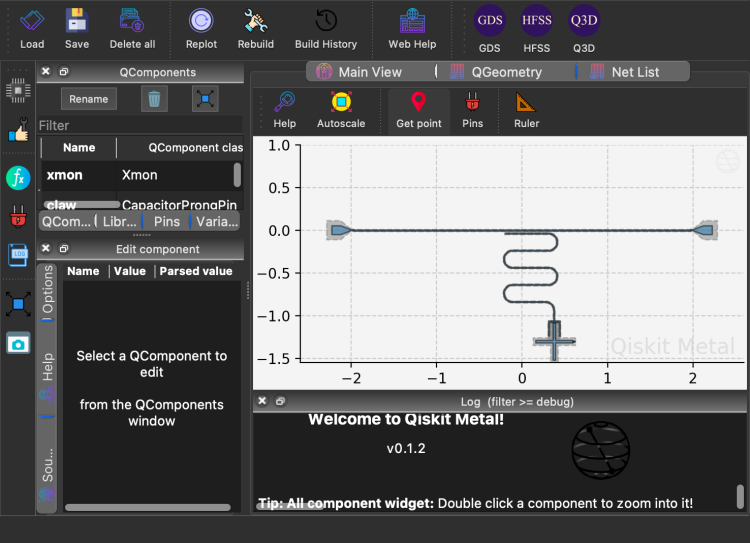

In [20]:
# rebuild the GUI
design.rebuild()
gui.rebuild()
gui.autoscale()
gui.screenshot('figures/qubit-cavity.png')

Define the hyper-parameters for the eigenmode simulation

In [21]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

import gmsh
gmsh.initialize()

In [28]:
from SQDMetal.PALACE.Eigenmode_Simulation import PALACE_Eigenmode_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                 "mesh_refinement":  0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                 "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                 "starting_freq": 3e9,                              #starting frequency in Hz 
                 "number_of_freqs": 3,                              #number of eigenmodes to find
                 "solns_to_save": 3,                                #number of electromagnetic field visualizations to save
                 "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                 "solver_tol": 1.0e-3,                              #error residual tolerance foriterative solver
                 "solver_maxits": 3,                              #number of solver iterations
                 "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                 "mesh_min": 10e-3,                                 #minimum element size for the mesh in mm
                 "mesh_sampling": 130,                              #number of points to mesh along a geometry
                 "fillet_resolution":12,   
                 "num_cpus": 1,                                      #number of CPU cores to use for simulation
                 "palace_dir":path_to_palace
                }

#Creat the Palace Eigenmode simulation
eigen_sim = PALACE_Eigenmode_Simulation(name ='qubit-cavity-eig',                              #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                               #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                         #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True)                                        #create mesh, config and HPC batch files


Assigning the materials to the interfaces, add ports to the design, and add some mesh.

In [ ]:
bounds = design.components["xmon"].qgeometry_bounds()
bounds

In [29]:
from SQDMetal.Utilities.Materials import MaterialInterface

eigen_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
eigen_sim.add_ground_plane(threshold=1e-10)

#Fine-mesh the transmon cross qubit region
eigen_sim.fine_mesh_in_rectangle(0.2875e-3, -1.2e-3, 0.63e-3, -1.72e-3, min_size=15e-6, max_size=120e-6)

#Add in the RF ports
eigen_sim.create_port_CPW_on_Launcher('LP1', 20e-6)
eigen_sim.create_port_CPW_on_Launcher('LP2', 20e-6)
eigen_sim.create_port_JosephsonJunction('junction', L_J=LJs[0]*1e-9, C_J=10e-15) # Guessing the C_J value really

# #Fine-mesh routed paths
eigen_sim.fine_mesh_around_comp_boundaries(['feedline', 'resonator'], min_size=25e-6, max_size=250e-6)
eigen_sim.fine_mesh_around_comp_boundaries(['xmon'], min_size=14e-6, max_size=75e-6)

eigen_sim.setup_EPR_interfaces(metal_air=MaterialInterface('Aluminium-Vacuum'), substrate_air=MaterialInterface('Silicon-Vacuum'), substrate_metal=MaterialInterface('Silicon-Aluminium'))

In [30]:
eigen_sim.prepare_simulation()

Checking the meshfile

In [122]:
from SQDMetal.PALACE.Utilities.GMSH_Navigator import GMSH_Navigator

gmsh_nav = GMSH_Navigator(eigen_sim.path_mesh)
gmsh_nav.open_GUI()

If all looks good, lets run the simulation

**NOTE:** If you are using a `palace` build that is from 2025, you will need to remove the `Excitation` key from the `LumpedPort` boundary condition in the `sim_config.json` file so please execute the following cell.

If you are using a `palace` build that is from 2024 or older, **you should skip this cell.**

In [ ]:
import json

with open(eigen_sim._sim_config, 'r') as file:
    sim_config_dict = json.load(file)

del sim_config_dict["Boundaries"]["LumpedPort"][0]["Excitation"]

with open(eigen_sim._sim_config, 'w') as file:
    json.dump(sim_config_dict, file, indent=4)

In [31]:
eigen_sim.run()

>> /opt/homebrew/bin/mpirun -n 1 /Users/shanto/LFL/palace/build/bin/palace-arm64.bin qubit-cavity-eig.json


[GlobalMachine.lan:01468] shmem: mmap: an error occurred while determining whether or not /var/folders/s5/b9svd25j78scrd1kw84_tcs00000gn/T//ompi.GlobalMachine.501/jf.0/4269735937/sm_segment.GlobalMachine.501.fe7f0001.0 could be created.



_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/

Git changeset ID: v0.13.0-117-g748660c
Running with 1 MPI process
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 2576 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 5362 duplicate vertices for interior boundaries in the mesh
Added 12769 duplicate boundary elements for interior boundaries in the mesh
Added 1550 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 1 subdomain

Characteristic length and time scales:
 L₀ = 5.520e-03 m, t₀ = 1.841e-02 ns

Mesh curvature order: 1
Mesh bounding box:
 (Xmin, Ymin, Zmin) = (-2.760e-03, -2.440e-03, -2.800e-04) m
 (Xmax, Ymax, Zmax) = (+2.760e-03, +4.400e-04, +2.800e-04) m

Parallel Mesh Stats:

                minimu

--------------------------------------------------------------------------
prterun noticed that process rank 0 with PID 1468 on node GlobalMachine exited on
signal 11 (Segmentation fault: 11).
--------------------------------------------------------------------------


Error in plotting: 'Data array (E_real) not present in this dataset.'


Reading the eigenmode data now

In [32]:
def read_csv_to_dataframe(file_path):
    return pd.read_csv(file_path)

eigen_df = read_csv_to_dataframe(os.path.join(eigen_sim._output_data_dir, 'eig.csv'))
eigen_df.columns = eigen_df.columns.str.strip()
eigen_df["kappa (kHz)"] = eigen_df["Re{f} (GHz)"] / eigen_df["Q"] * 1e6
eigen_df

,m,Re{f} (GHz),Im{f} (GHz),Q,Error (Bkwd.),Error (Abs.),kappa (kHz)
0,1.0,3.215370,-1.487712,1.190709,4.142376e-07,0.062280,2.700383e+06
1,2.0,3.915354,0.013413,145.956716,1.227601e-07,0.018457,2.682545e+04
2,3.0,8.909974,6.947827,0.813108,1.697317e-06,0.255208,1.095792e+07
3,4.0,9.472281,0.025372,186.668249,1.215369e-06,0.182739,5.074393e+04
4,5.0,10.996458,0.831058,6.634802,1.780067e-06,0.267649,1.657391e+06


Let's remind ourselves what we expected.

In [33]:
test_data.iloc[0]

qubit_frequency_GHz       4.621651
cavity_frequency_GHz      6.920735
anharmonicity_MHz      -194.264031
kappa_kHz               163.433945
g_MHz                   102.199270
Name: 0, dtype: float64

## EPR Calculations

Since `palace` does automatic postprocessing of energy-participation ratios (EPRs) for circuit quantization and interface or bulk participation ratios for predicting dielectric loss, we can use this to do some quantum analysis from the eigenmode simulation when lumped inductive elements (i.e. josephson junctions) exist in the simulated geometry.

First, we need to retrieve the mode-port EPRs from the eigenmode simulation.

In [34]:
mode_dict = eigen_sim.retrieve_mode_port_EPR_from_file(eigen_sim._output_data_dir)

#get particpation ratios and frequencies from the simulation
participation_ratios = mode_dict['mat_mode_port']
frequencies = mode_dict['eigenfrequencies']

We have identified the qubit and cavity modes from the eigenmode simulation as mode 3 and mode 4 respectively.

In [35]:
qubit_idx = 1
cavity_idx = 2

In [36]:
linear_qubit_freq = eigen_df['Re{f} (GHz)'][qubit_idx]*1e9
linear_res_freq = eigen_df['Re{f} (GHz)'][cavity_idx]*1e9
P_qubit = abs(participation_ratios[qubit_idx, 0])
P_cav = abs(participation_ratios[cavity_idx, 0])
kappa = eigen_df['kappa (kHz)'][cavity_idx]

In [37]:
P_qubit, P_cav

(0.8103038952, 6.350833133e-05)

Now, let's calculate the qubit and cavity Hamiltonian parameters using these participation ratios.

In [38]:
#Constants used for calculations
from scipy.constants import Planck, e, hbar
phi0 = hbar/(2*e)

#Josephson Energy (Ej) and linear inductance (Lj)
delta_super = (1.8e-4 / 2) * e
Lj = LJs[0]*1e-9
Ej = phi0**2 / Lj

#Normalize Participation Ratios
P_qubit_normalised = P_qubit / (P_qubit + P_cav)
P_cav_normalised = P_cav / (P_qubit + P_cav)

#Enter in Frequencies from Simulation
omega_qubit = 2 * np.pi * linear_qubit_freq
omega_res = 2 * np.pi * linear_res_freq

#phi zero-point fluctuations for qubit
phi_zpf_sq = P_qubit * hbar * 2 * omega_qubit  / (2*Ej)

#anharmonicity qubit (self kerr)
anharm_qubit = P_qubit**2 * hbar * omega_qubit**2 / (8*Ej)

#anharmonicity resonator (self kerr)
anharm_res = P_cav**2 * hbar * omega_res**2 / (8*Ej)

#Charging Energy (Ec)
Ec = anharm_qubit * hbar

#Total Capacitance
C_total = e**2 / (2*Ec)

#cross kerr - dispersive shit (chi)
cross_kerr = (P_qubit * P_cav * hbar * omega_qubit * omega_res) / (4*Ej)

#lamb-shift of qubit frequency
lamb_shift_qubit = anharm_qubit - cross_kerr/2

#lamb-shift of res frequency
lamb_shift_res = anharm_res - cross_kerr/2

#detuning, delta
delta = ((linear_res_freq - anharm_res/(2*np.pi)) - (linear_qubit_freq - anharm_qubit/(2*np.pi)))

#resonator-qubit coupling strength (g)
disp_shift_qubit = cross_kerr
g_rwa = np.sqrt(disp_shift_qubit * delta  * (1 + delta/anharm_qubit))

# coupling strength (g) from SQuADDS Paper
Delta = omega_res - omega_qubit      # rad/s
Sigma = omega_res + omega_qubit      # rad/s
alpha = -anharm_qubit                # rad/s (already angular)
chi = -disp_shift_qubit              # rad/s (already angular)
# Denominator (s/rad)
denom = (alpha / (Delta * (Delta - alpha))) - (alpha / (Sigma * (Sigma + alpha)))

# Convert to linear frequency in MHz (optional, for reporting)
g_rad = np.sqrt(chi / (2 * denom))     # rad/s
g_MHz = g_rad / (2 * np.pi * 1e6)    # MHz

Interesting to check what `scqubits` says about the Hamiltonian parameters computed using the simulation results.

In [39]:
import scqubits as scq
from scqubits.core.transmon import Transmon

scq.set_units("GHz")

# Using scqubits to find the Josephson energy and charging energy using the qubit frequency and anharmonicity from EPR
qubit_freq_GHz = linear_qubit_freq/1e9 - lamb_shift_qubit/(2*np.pi*1e9)
qubit_anharm_GHz = (alpha*1e-9)/(2*np.pi)
EJ_scq, EC_scq = Transmon.find_EJ_EC(qubit_freq_GHz, qubit_anharm_GHz)


# Using scqubits to find the qubit frequency and anharmonicity now using the Josephson energy and charging energy from EP
EJ_GHz = Ej / (hbar * 2 * np.pi *  1e9)
EC_GHz = anharm_qubit  / (2*np.pi*1e9)
transmon = Transmon(EJ=EJ_GHz, EC=EC_GHz, ng=0, ncut=30)
qubit_freq_scq= transmon.E01()
anharm_qubit_scq = transmon.anharmonicity() * 1E3  # MHz

# Using scqubits to find the C_qubit capacitance

def C_qubit_from_Ec(Ec):
    """
    Calculate the capacitance (C_qubit) in fF from the charging energy (Ec) in GHz.
    """
    Ec_Joules = Ec * 1e9 * Planck
    Cs_SI = (e ** 2) / (2 * Ec_Joules)
    Cs_fF = Cs_SI * 1e15
    return Cs_fF

C_qubit_scq = C_qubit_from_Ec(EC_scq)

In [40]:
hamiltonian_params = [
    ("Ej", Ej / (hbar * 2 * np.pi *  1e9), "GHz"),
    ("Ej (scqubits)", EJ_scq, "GHz"),
    ("Ec", anharm_qubit  / (2*np.pi*1e9), "GHz"),
    ("Ec (scqubits)", EC_scq, "GHz"),
    ("Ej/Ec", Ej/Ec, "unitless"),
    ("Ej/Ec (scqubits)", EJ_scq/EC_scq, "unitless"),
    ("Lj", Lj/1e-9, "nH"),
    ("C_qubit", C_total/1e-15, "fF"),
    ("C_qubit (scqubits)", C_qubit_scq, "fF"),
    ("Participation Ratio Qubit", P_qubit, "unitless"),
    ("Participation Ratio Qubit (Normalized)", P_qubit_normalised, "unitless"),
    ("Participation Ratio Cavity", P_cav, "unitless"),
    ("Participation Ratio Cavity (Normalized)", P_cav_normalised, "unitless"),
    ("Linear Qubit Frequency", linear_qubit_freq/1e9, "GHz"),
    ("Qubit Frequency", linear_qubit_freq/1e9 - lamb_shift_qubit/(2*np.pi*1e9), "GHz"),
    ("Qubit Frequency (scqubits)", qubit_freq_scq, "GHz"),
    ("Qubit Anharmonicity", -anharm_qubit / (2*np.pi*1e6), "MHz"),
    ("Qubit Anharmonicity (scqubits)", anharm_qubit_scq, "MHz"),
    ("Linear Cavity Frequency", linear_res_freq/1e9, "GHz"),
    ("Cavity Frequency", linear_res_freq/1e9 - lamb_shift_res/(2*np.pi*1e9), "GHz"),
    ("Cavity Anharmonicity", anharm_res / (2*np.pi*1e6), "MHz"),
    ("Cavity Linewidth", kappa, "kHz" ),
    ("Dispersive Shift (chi)", cross_kerr/ (2*np.pi*1e6), "MHz"),
    ("Cavity-Qubit Coupling [Ref. SQuADDS], g", g_MHz, "MHz"),
    ("Cavity-Qubit Coupling [RWA], g", g_rwa/(2*np.pi*1e6), "MHz"),
    ("Detuning", delta/1e9, "GHz"),
    ("Flux_ZPF_squared", phi_zpf_sq, "unitless"),
]

# Create DataFrame
hamiltonian_df = pd.DataFrame(hamiltonian_params, columns=["Parameter", "Value", "Unit"])

# Function to format values
def format_float_six_decimal(val, idx):
    return f"{val:.6f}"

# Apply formatting
hamiltonian_df['Value'] = [
    format_float_six_decimal(val, idx) for idx, val in enumerate(hamiltonian_df['Value'])
]

print(hamiltonian_df.to_string(index=False))

                              Parameter           Value     Unit
                                     Ej       16.346243      GHz
                          Ej (scqubits)       26.023930      GHz
                                     Ec        0.076972      GHz
                          Ec (scqubits)        0.073561      GHz
                                  Ej/Ec      212.367454 unitless
                       Ej/Ec (scqubits)      353.772700 unitless
                                     Lj        9.999944       nH
                                C_qubit      251.654540       fF
                     C_qubit (scqubits)      263.321427       fF
              Participation Ratio Qubit        0.810304 unitless
 Participation Ratio Qubit (Normalized)        0.999922 unitless
             Participation Ratio Cavity        0.000064 unitless
Participation Ratio Cavity (Normalized)        0.000078 unitless
                 Linear Qubit Frequency        3.915354      GHz
                        Q

In [41]:
%matplotlib inline

 /var/folders/s5/b9svd25j78scrd1kw84_tcs00000gn/T/ipykernel_665/709082075.py: 48
 /var/folders/s5/b9svd25j78scrd1kw84_tcs00000gn/T/ipykernel_665/709082075.py: 57


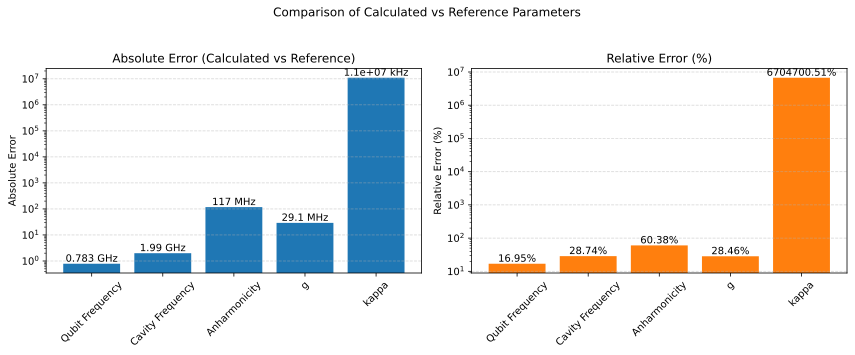

       Parameter    Reference      Calculated Absolute Error Relative Error (%)
 Qubit Frequency  4.62165 GHz      3.8384 GHz      0.783 GHz             16.95%
Cavity Frequency  6.92073 GHz     8.90999 GHz       1.99 GHz             28.74%
   Anharmonicity -194.264 MHz    -76.9715 MHz        117 MHz             60.38%
               g  102.199 MHz     73.1173 MHz       29.1 MHz             28.46%
           kappa  163.434 kHz 1.09579e+07 kHz    1.1e+07 kHz        6704700.51%


In [43]:
# Helper to extract values from hamiltonian_df
def get_param_value(param_name, unit=None):
    row = hamiltonian_df[hamiltonian_df["Parameter"] == param_name]
    if row.empty:
        raise ValueError(f"Parameter '{param_name}' not found in hamiltonian_df")
    val = float(row["Value"].values[0])
    return val

# Gather calculated and reference values, with units
param_info = [
    ("Qubit Frequency", "Qubit Frequency", "qubit_frequency_GHz", "GHz"),
    ("Cavity Frequency", "Cavity Frequency", "cavity_frequency_GHz", "GHz"),
    ("Anharmonicity", "Qubit Anharmonicity", "anharmonicity_MHz", "MHz"),
    ("g", "Cavity-Qubit Coupling [Ref. SQuADDS], g", "g_MHz", "MHz"),
    ("kappa", "Cavity Linewidth", "kappa_kHz", "kHz"),
]

calc_vals = []
ref_vals = []
labels = []
units = []

for label, hdf_name, test_col, unit in param_info:
    calc = get_param_value(hdf_name, unit)
    ref = test_data.iloc[0][test_col]
    calc_vals.append(calc)
    ref_vals.append(ref)
    labels.append(label)
    units.append(unit)

calc_vals = np.array(calc_vals)
ref_vals = np.array(ref_vals)
abs_errs = np.abs(calc_vals - ref_vals)
rel_errs = abs_errs / np.abs(ref_vals + 1e-12)  # avoid div by zero

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Absolute error bar plot
axs[0].bar(labels, abs_errs, color='tab:blue')
for i, v in enumerate(abs_errs):
    axs[0].text(i, v, f"{v:.3g} {units[i]}", ha='center', va='bottom', fontsize=10)
axs[0].set_ylabel("Absolute Error")
axs[0].set_title("Absolute Error (Calculated vs Reference)")
axs[0].grid(axis='y', linestyle='--', alpha=0.5)
axs[0].set_yscale("log")
axs[0].set_xticklabels(labels, rotation=45)

# Relative error bar plot
axs[1].bar(labels, rel_errs * 100, color='tab:orange')
for i, v in enumerate(rel_errs):
    axs[1].text(i, v*100, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=10)
axs[1].set_ylabel("Relative Error (%)")
axs[1].set_title("Relative Error (%)")
axs[1].grid(axis='y', linestyle='--', alpha=0.5)
axs[1].set_xticklabels(labels, rotation=45)

plt.suptitle("Comparison of Calculated vs Reference Parameters")
plt.yscale("log")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Also print a table for clarity
import pandas as pd
summary_df = pd.DataFrame({
    "Parameter": labels,
    "Reference": [f"{v:.6g} {u}" for v, u in zip(ref_vals, units)],
    "Calculated": [f"{v:.6g} {u}" for v, u in zip(calc_vals, units)],
    "Absolute Error": [f"{v:.3g} {u}" for v, u in zip(abs_errs, units)],
    "Relative Error (%)": [f"{v*100:.2f}%" for v in rel_errs],
})
print(summary_df.to_string(index=False))

At first glance, the results might seem underwhelming—so either

a) our model predictions are way off

b) the simulations are correct and the model predictions are way off.

In this case, it's much more likely the latter: recall that this **eigenmodal** simulation finished in under 3 minutes, which is **extremely fast** for this type of problem and suggests the mesh and solver tolerances are quite loose.

In fact, aside from the cavity linewidth (kappa), the fact that we're getting sensible values for the other parameters is actually promising for both the ML model and the simulator. With improved simulation hyperparameters (e.g., finer mesh, tighter tolerances), we can expect even better agreement and more reliable validation of the ML predictions.

## Task 1: Improve and Deploy the ML Model for the Interpolation Problem

Your goal is to improve the accuracy of the neural network that predicts geometric parameters from Hamiltonian targets. You can either:

* **Tune hyperparameters** of the provided MLP (e.g., hidden layers, activation functions, learning rate, optimizer), or
* **Design and train your own model architecture** from scratch using any method you like (e.g., PyTorch, Keras).

Once you obtain predictions, **validate them using Palace simulations** to check if the predicted design actually recovers the target Hamiltonian. You are also encouraged to optimize **Palace simulation settings** (e.g., mesh density, solver tolerances) to ensure accurate validation.

### Deploy Your Improved ML Model to HuggingFace

Once you have developed a model that you are happy with and ideally performs really well, you can deploy it to HuggingFace for others to use.

HuggingFace makes it ridiculously easy to deploy an ML model. All you need to do is:

1. Load the model.
2. Save the model in the format required by HuggingFace.

```python
from tensorflow.keras.models import load_model
model=load_model("path/to/model.keras")
model.save(f"hf://{hf_username}/{model_name}")
```

If your model is **REALLYYYYY good**, then send me an [email](mailto:shanto@usc.edu) with the link to your model and I will add it to the SQuADDS ML model collection.

In [ ]:
# your code here

---

## Mapping Out The Design-Hamiltonian Space

We propose a two-model architecture to understand the physics of the Hamiltonian-Design space mapping. 

1. **Design-Relevance Encoder**
   The first stage is a lightweight model (e.g., Random Forest or Lasso) that **identifies the subset of geometric design parameters most relevant** to each Hamiltonian parameter. This compresses the full design space into a minimal, interpretable feature subset for each target Hamiltonian.

2. **KAN-based Symbolic Decoder**
    The second model, a **Kolmogorov–Arnold Network (KAN)** is trained to **symbolically model the Hamiltonian parameter** as a function of only its relevant design variables. The KAN outputs a closed-form symbolic expression, enabling direct interpretation of the underlying physics-driven dependency.


## Design-Relevance Encoder

The **Design-Relevance Encoder** identifies which geometric parameters $\boldsymbol{\xi}$ most influence each target Hamiltonian parameter $\hat{\mathcal{H}}$. To do this, we train an interpretable model — **Lasso regression**  — to predict each Hamiltonian component from the full set of geometric inputs.

* **Lasso (Least Absolute Shrinkage and Selection Operator)** selects relevant features via coefficient shrinkage, automatically zeroing out irrelevant ones.

By using this model's outputs we construct a relevance mask that tells us which subset of design parameters significantly affect each $\hat{\mathcal{H}}$. This subset is then used as input to symbolic regression (e.g. KAN) to extract compact, human-readable expressions.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import sympy as sp
import matplotlib.pyplot as plt
import random

In [3]:
training_df = pd.read_parquet("data/training_data.parquet")

In [4]:
hamiltonian_parameters = ['qubit_frequency_GHz', 'anharmonicity_MHz', 'cavity_frequency_GHz', 'kappa_kHz', 'g_MHz']
design_parameters = ['cross_length', 'claw_length','coupling_length', 'total_length','ground_spacing']

In [5]:
Y_hamiltonian = training_df[hamiltonian_parameters].values # Hamiltonian parameters
X_design = training_df[design_parameters].values # Design parameters

In [8]:
from squadds_ml_utils import *

In [9]:
ml_analyzer = DesignToHamiltonianAnalyzer(
    X_design, 
    Y_hamiltonian, 
    design_labels=design_parameters,
    hamiltonian_labels=hamiltonian_parameters
)


In [10]:
ml_analyzer.run_multitask_lasso()

,qubit_frequency_GHz,anharmonicity_MHz,cavity_frequency_GHz,kappa_kHz,g_MHz
cross_length,-0.956645,0.904895,0.000207,0.000060,-0.574872
claw_length,-0.005958,0.007807,-0.220192,-0.141799,0.932547
coupling_length,-0.000277,0.000236,-0.153045,0.877849,-0.073914
total_length,0.000482,-0.000646,-0.924025,-0.484510,-0.394851
ground_spacing,-0.001715,0.002270,0.000009,0.000282,-0.350630


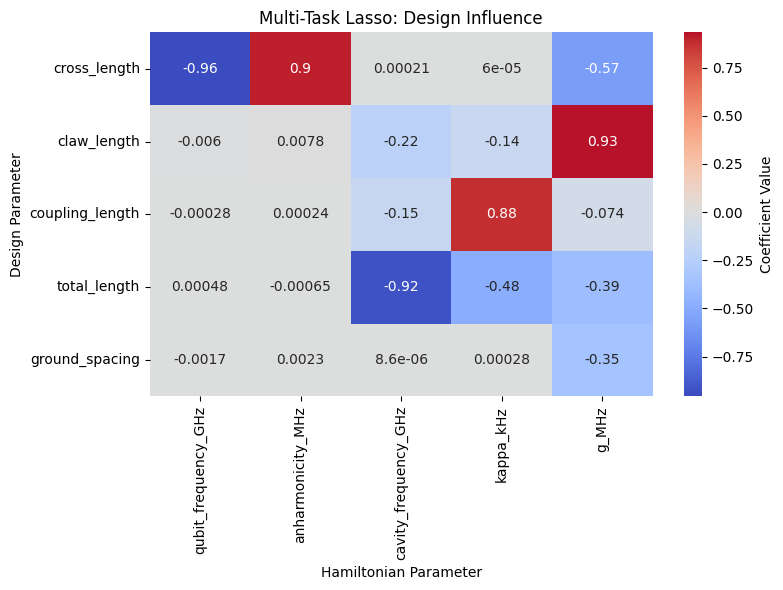

In [11]:
ml_analyzer.plot_heatmap()

In [12]:
dependency_summary = ml_analyzer.get_dependency_summary_json(top_k=2, threshold=0.1)


=== Dependency Summary (Top 2 per Hamiltonian parameter, threshold=0.1) ===
{
    "lasso": {
        "qubit_frequency_GHz": [
            {
                "parameter": "cross_length",
                "coef": -0.9566450702950791
            }
        ],
        "anharmonicity_MHz": [
            {
                "parameter": "cross_length",
                "coef": 0.9048951896959866
            }
        ],
        "cavity_frequency_GHz": [
            {
                "parameter": "total_length",
                "coef": -0.9240245095005699
            },
            {
                "parameter": "claw_length",
                "coef": -0.22019159774694974
            }
        ],
        "kappa_kHz": [
            {
                "parameter": "coupling_length",
                "coef": 0.8778486103726036
            },
            {
                "parameter": "total_length",
                "coef": -0.4845101405098588
            }
        ],
        "g_MHz": [
            {
   

## KAN Decoder

The KAN (Kolmogorov–Arnold Network) decoder learns a compact symbolic expression for a Hamiltonian parameter based on a subset of relevant geometric features. Unlike traditional neural networks, KAN explicitly fits interpretable functional forms using trainable basis functions, revealing the underlying physics in closed-form expressions. After training, the network can be pruned and symbolic expressions extracted using a user-defined library of functions, yielding formulas that capture how design geometry affect the Hamiltonian parameters

### Feature and Target Selection

For the KAN model, let's first choose the Hamiltonian parameter we want to model — in this case, the coupling strength $g$ (in MHz). From the Design-Relevance Encoder model, **`cross_length`** and **`claw_length`** emerged as the two most relevant design parameters for `g_MHz`. 

Lets process the training dataset then.


In [13]:
target_feature = 'cavity_frequency_GHz'

In [14]:
input_features = [i["parameter"] for i in dependency_summary["lasso"][target_feature]]
input_features

['total_length', 'claw_length']

In [15]:
X = training_df[input_features].values
y = training_df[target_feature].values.reshape(-1, 1)

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)


# Convert to PyTorch tensors
train_input = torch.tensor(X_train, dtype=torch.float32)
test_input = torch.tensor(X_val, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32)
test_label = torch.tensor(y_val, dtype=torch.float32)

# Final dataset dict for pykan
dataset = {
    "train_input": train_input,
    "test_input": test_input,
    "train_label": train_label,
    "test_label": test_label
}


### KAN Model Setup

We now define and initialize the Kolmogorov–Arnold Network (KAN) model to learn a symbolic expression for the Hamiltonian parameter $f_{cav}$. The chosen architecture `KAN(width=[2, 2, 1], grid=5, k=3)` reflects:

* **Input layer** with 2 neurons for the two most relevant geometric features: `total_length` and `claw_length`.
* **One hidden layer** with 2 units, each equipped with a set of grid-based basis functions.
* **Output layer** producing a single scalar value corresponding to `cavity_frequency_GHz`.

The `grid` parameter sets how many grid points each neuron's nonlinear activation uses: increasing `grid` allows the model to capture more complex, detailed functions, but may reduce smoothness and interpretability; decreasing it makes the model simpler and smoother, but less expressive. The `k` parameter controls local smoothing by determining how many nearby grid points influence each output: higher `k` values produce smoother, more robust functions, while lower `k` values allow for sharper, more localized changes in the learned function.


Setting random seed to 0 to ensure reproducibility 🤞🏽

In [16]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [17]:
from kan import *

checkpoint directory created: ./model
saving model version 0.0


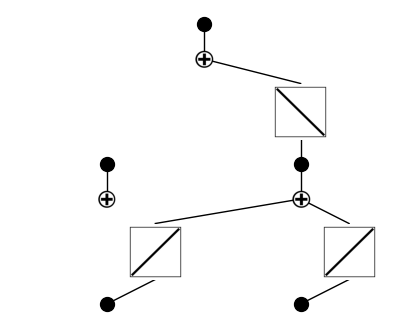

In [18]:
model = KAN(width=[2,2,1], grid=5, k=3)
model(dataset['train_input']);
model.plot(beta=100)

This plot shows the untrained KAN model for predicting cavity frequency from `total_length` and `claw_length`. Each black dot represents an input, which is passed through learnable univariate function blocks (squares) that apply symbolic transformations (e.g., `x`, `x²`, `sin`). These transformed features are summed (white “+” nodes) to build the output. At this stage, all functions are uninitialized (linear ramps), and the structure reflects the model's capacity to discover symbolic patterns through training.

### Encouraging Symbolic Simplicity

Before training, we configure two key regularization terms that guide the KAN model toward interpretable symbolic solutions:

* **`lamb` (L2 sparsity penalty):** This term encourages the weights of the model to be small, reducing model complexity. A higher value forces the network to use fewer basis functions and promotes sparsity in the learned representation.

* **`lamb_entropy` (functional entropy penalty):** This term penalizes overly complex or chaotic nonlinear transformations by minimizing the entropy of the learned functional basis. It nudges the network to favor smooth, low-entropy functions like polynomials, sinusoids, or exponentials.

Together, these regularizers bias the training process toward compact, human-readable formulas instead of overfitted black-box predictions.

In [19]:
metrics = model.fit(dataset, steps=100, lamb=0.01, lamb_entropy=10)

description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 3.28e-01 | test_loss: 3.30e-01 | reg: 5.57e+00 | : 100%|█| 100/100 [03:07<00:00,  1.87

saving model version 0.1


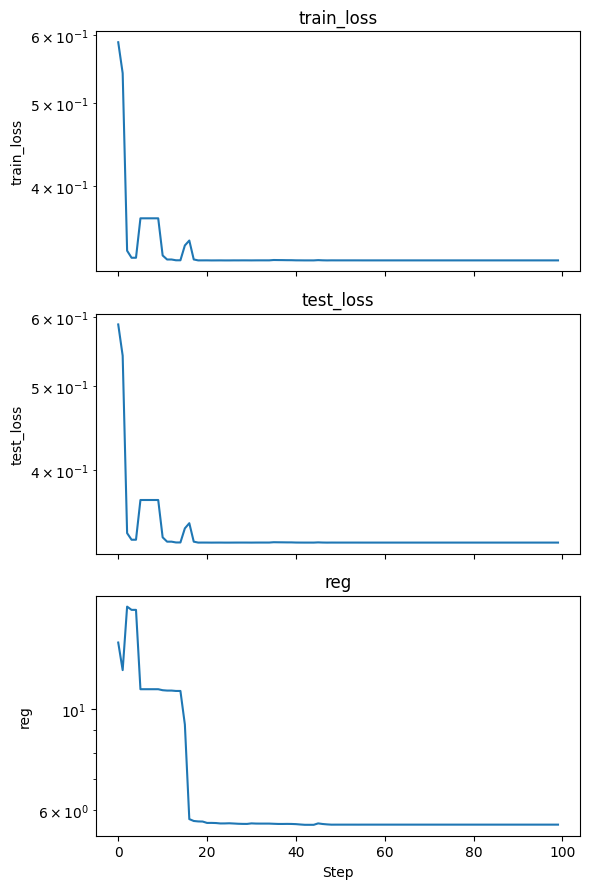

In [20]:
fig, axs = plt.subplots(len(metrics), 1, figsize=(6, 3 * len(metrics)), sharex=True)
if len(metrics) == 1:
    axs = [axs]
for i, key in enumerate(metrics.keys()):
    axs[i].plot(metrics[key])
    axs[i].set_yscale('log')
    axs[i].set_title(key)
    axs[i].set_ylabel(key)
axs[-1].set_xlabel('Step')
plt.tight_layout()
plt.show()

Lets visualize the trained KAN model.

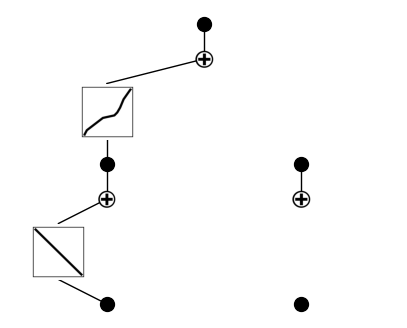

In [21]:
model.plot()

After training, the model has learned to rely primarily on the total meander length input, passing it through two distinct nonlinear transformations before summing their outputs to predict the target. The claw length input remains disconnected, indicating it was not found to be predictive by the network during optimization.

As a best practice, we prune the model at this stage to remove redundant or low-contribution paths. This step simplifies the learned symbolic equation, making it more interpretable by eliminating unnecessary neurons and connections that do not significantly impact the prediction. Pruning refines the model architecture before further fine-tuning.

saving model version 0.2


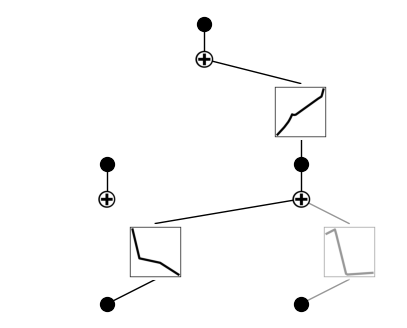

In [80]:
model = model.prune()
model(dataset['train_input'])
model.plot()


The updated architecture clearly shows that the model now relies on distinct nonlinear transformations of both inputs (total meander length and claw length), though one transformation from claw length is weak and de-emphasized.

We retrain after pruning to slightly adjust the remaining functions for better accuracy.

In [ ]:
model.fit(dataset, steps=50)
try:
    model.plot()
except Exception as e:
    print("Error plotting model")


Finally, we define a library of candidate symbolic functions (polynomials, sinusoids, logs, etc.). KAN fits the learned internal structure to combinations of these and then extracts the final symbolic formula representing:

$$
{f_{cav}} = f(\text{cross\_length}, \text{claw\_length})
$$


In [94]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=1.0000004768371582, c=1
fixing (0,0,1) with x, r2=1.0000004768371582, c=1
fixing (0,1,0) with sin, r2=0.9420685172080994, c=2
fixing (0,1,1) with x, r2=0.007256615906953812, c=1
fixing (1,0,0) with x, r2=0.9558318853378296, c=1
fixing (1,1,0) with x, r2=0.001895315945148468, c=1
saving model version 0.2


In [95]:
model.symbolic_formula()

([-0.00169442449984271*x_1 - 5.35003944827876e-12*x_2 - 5.43009030583892e-6*sin(9.40023994445801*x_2 - 9.61199951171875) + 13.2851943596568],
 [x_1, x_2])

Lets visually interpret the symbolic model and compare it to the data.

In [98]:
def plot_symbolic_surface(f_sym, x1_range, x2_range, x1_label, x2_label, z_label, title, cmap='plasma'):
    """
    Plots a 2D surface of a symbolic model f_sym(x1, x2) over the specified ranges.
    """
    X2, X1 = np.meshgrid(x2_range, x1_range)
    Z = f_sym(X1, X2)
    plt.figure(figsize=(6, 6))
    c = plt.pcolormesh(x2_range, x1_range, Z, shading='auto', cmap=cmap)
    plt.xlabel(x2_label, fontsize=12)
    plt.ylabel(x1_label, fontsize=12)
    cbar = plt.colorbar(c, label=z_label)
    cbar.ax.tick_params(labelsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=13)
    plt.tight_layout()
    plt.show()

def plot_symbolic_vs_data(f_sym, x1_vals, fixed_x2, real_X, real_y, x1_col, x2_col, tol, x1_label, x2_label, y_label, title):
    """
    Plots the symbolic model prediction vs. real data for a fixed x2 value.
    """
    f_pred = f_sym(x1_vals, fixed_x2)
    mask = np.abs(real_X[:, x2_col] - fixed_x2) < tol
    x1_real = real_X[mask, x1_col]
    y_real = real_y[mask]
    plt.figure(figsize=(8, 6))
    plt.plot(x1_vals, f_pred, label=f'Symbolic Model (fixed {x2_label}={fixed_x2})', color='C0')
    plt.scatter(x1_real, y_real, color='C1', edgecolor='k', s=40,
                label=f'Real Data (fixed {x2_label}={fixed_x2}±{tol})')
    plt.xlabel(x1_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

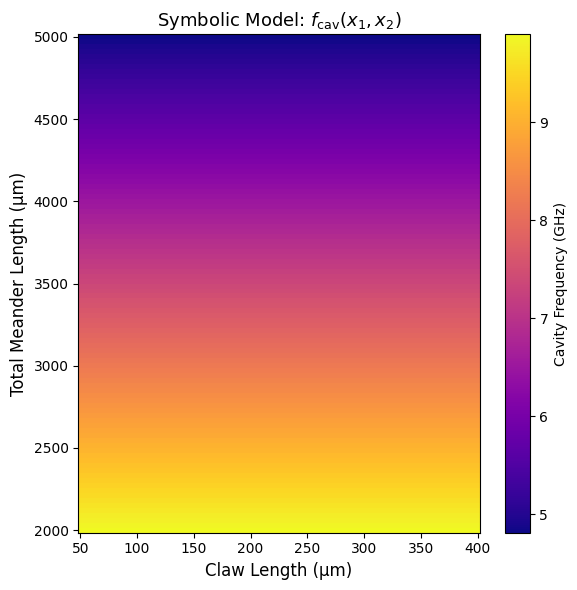

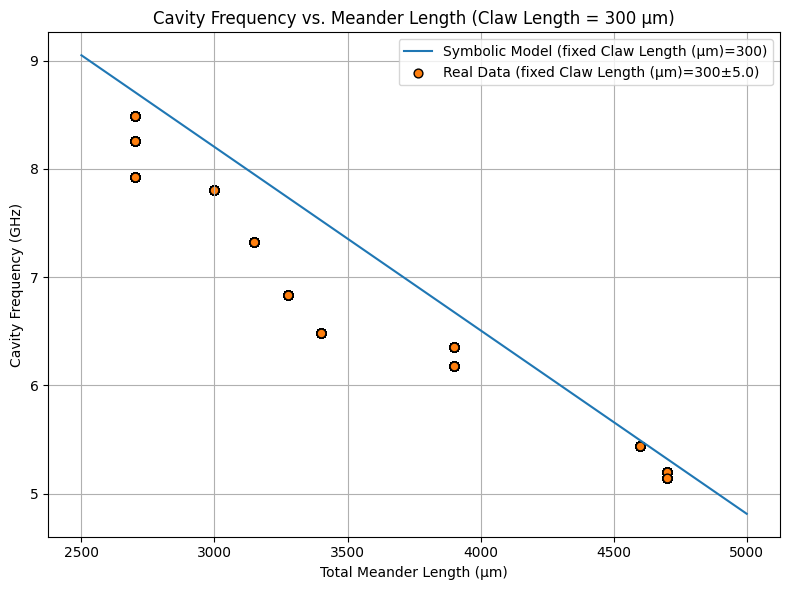

In [ ]:
# Define symbolic model
x1, x2 = sp.symbols('x_1 x_2')
expr = (-0.00169442449984271*x1 - 5.35003944827876e-12*x2 - 5.43009030583892e-6*sin(9.40023994445801*x2 - 9.61199951171875) + 13.2851943596568)
f_sym = sp.lambdify((x1, x2), expr, modules='numpy')

# 1. Surface plot
claw_vals = np.linspace(50, 400, 100)       # x2: claw length [µm]
meander_vals = np.linspace(2000, 5000, 100) # x1: total meander length [µm]
plot_symbolic_surface(
    f_sym,
    x1_range=meander_vals,
    x2_range=claw_vals,
    x1_label='Total Meander Length (µm)',
    x2_label='Claw Length (µm)',
    z_label='Cavity Frequency (GHz)',
    title=r'Symbolic Model: $f_{\mathrm{cav}}(x_1, x_2)$'
)

# 2. Symbolic vs. data plot
fixed_claw = 300
x1_vals = np.linspace(2500, 5000, 200)
input_features = ['total_length', 'claw_length']
target_feature = 'cavity_frequency_GHz'
X = training_df[input_features].values
y = training_df[target_feature].values.reshape(-1)
tol = 5.0  # microns

# x1_col=0 (total_length), x2_col=1 (claw_length)
plot_symbolic_vs_data(
    f_sym,
    x1_vals=x1_vals,
    fixed_x2=fixed_claw,
    real_X=X,
    real_y=y,
    x1_col=0,
    x2_col=1,
    tol=tol,
    x1_label='Total Meander Length (µm)',
    x2_label='Claw Length (µm)', 
    y_label='Cavity Frequency (GHz)',
    title=f'Cavity Frequency vs. Meander Length (Claw Length = {fixed_claw} µm)'
)

The symbolic expression returned by the KAN model is:

$$
f_{cav}(x_1, x_2) = a_1 x_1 + a_2 x_2 + a_3 \sin(b_1 x_2 + b_2) + a_4
$$

with the following numerical values:

* $a_1 = -1.694 \times 10^{-3}$
* $a_2 = -5.35 \times 10^{-12}$
* $a_3 = -5.43 \times 10^{-6}$
* $b_1 = 9.40$, $b_2 = -9.61$
* $a_4 = 13.285$

### Dimensional Analysis and Simplification

In our dataset:

* $x_1 \in [2000, 5000] \, \mu\text{m}$
* $x_2 \in [100, 400] \, \mu\text{m}$

We can estimate the magnitude of each term:

* $a_1 x_1 \sim - 3.5$ — dominant term
* $a_2 x_2 \sim 10^{-9}$ — negligible
* $a_3 \sin(\cdot) \sim 10^{-6}$ — negligible
* $a_4 \sim 13.3$ — dominant constant offset

Thus, to leading order, the model simplifies to:

$$
f_{cav}(x_1, x_2) \approx a_1 x_1 + a_4
$$


### Interpretation
 
In summary, the model shows that total meander length $x_1$ is the dominant factor affecting cavity frequency, with other terms (including those involving claw length $x_2$) being negligible. This matches physical expectations and demonstrates that the symbolic formula found by KAN is both accurate and interpretable, serving as a reliable and efficient surrogate for more complex simulations.

**Note:** KAN model outcomes are probabilistic—if you do not set a deterministic random seed, you may not obtain the exact same symbolic model or results each time you run this notebook. Additionally, the hyperparameters used here are not fully optimized; further tuning will certainly yield improved performance and interpretability at the cost of training time.

---


## Task 2: Symbolic Discovery with KANs Using Design-Relevance Insights

Your goal is to explore **symbolic relationships between Hamiltonian parameters and the most relevant design variables** using a KAN model

Start by choosing a Hamiltonian parameter of interest (e.g., $g$, $\alpha_q$) and use the **design-relevance encoder** outputs to identify which geometry parameters matter most for that target.

Then:

* Use those selected design variables as inputs to the KAN model.
* Train KAN to **learn an interpretable symbolic mapping** from geometry to the Hamiltonian parameter.

Try different architectures, libraries of functions, and pruning thresholds to extract concise and meaningful symbolic expressions. The goal is to gain **physical insight** into how specific design features influence device behavior — not just predict, but understand.

If your symbolic model makes sense and teaches us something cool, shoot us an [email](mailto:shanto@usc.edu).

In [41]:
# ------------------------------
# Helpful to fix the random seed
# ------------------------------
SEED =5202025
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# your code here

## Task 3: 

I had a similar model (no hyperparameter tuning) for that predicted the following for the coupling strength, $g$:

$$
g(x_1, x_2) = 1.2306 \cdot x_1 + 0.6623 \cdot x_2 - 848.14 \cdot \sqrt{0.00559 \cdot x_1 + 0.00134 \cdot x_2 + 1} + 1016.44
$$

Writing it without the constants:

$$
g(x_1, x_2) = a_1 x_1 + a_2 x_2 - b \cdot \sqrt{c_1 x_1 + c_2 x_2 + 1} + d
$$

Where:
- $x_1$: cross length (in microns)  
- $x_2$: claw length (in microns)  
- $a_1, a_2$: linear gain coefficients  
- $b$: scale of nonlinear saturation  
- $c_1, c_2$: coupling weightings inside the square root  
- $d$: baseline offset  

It seems to have fitted our data very well. 

<div style="display: flex; justify-content: space-between; margin: 20px 0;">
    <div style="flex: 1; margin: 0 10px;">
        <h3>Reference plot from the SQuADDS paper</h3>
        <img src="paper-plot.png" alt="Plot 1" style="width: 100%;">
    </div>
    <div style="flex: 1; margin: 0 10px;">
        <h3>Comparision plot to the SQuADDS paper from the model</h3>
        <img src="g_plot.png" alt="Plot 2" style="width: 100%;">
    </div>
    <div style="flex: 1; margin: 0 10px;">
        <h3>Model prediction</h3>
        <img src="g_pred.png" alt="Plot 3" style="width: 100%;">
    </div>
</div>

Discuss amongst yourselves to see if this expression is physically meaningful or not. 

## License

<div style='width: 100%; background-color:#3cb1c2;color:#324344;padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>
    <h3>This code is a part of SQuADDS</h3>
    <p>Developed by Sadman Ahmed Shanto</p>
    <p>This tutorial is written by Sadman Ahmed Shanto</p> 
    <p>&copy; Copyright Sadman Ahmed Shanto & Eli Levenson-Falk 2025.</p>
    <p>This code is licensed under the MIT License. You may<br> obtain a copy of this license in the LICENSE.txt file in the root directory<br> of this source tree.</p>
    <p>Any modifications or derivative works of this code must retain this<br>copyright notice, and modified files need to carry a notice indicating<br>that they have been altered from the originals.</p>
</div>